# Problem

Build a machine learning model that can predict the severity of heart condition for a given set of reading. The severity ranges from 0 (low) to 4 (highest).

Attributes to be used:

1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type
        Value 1: typical angina
        Value 2: atypical angina
        Value 3: non-anginal pain
        Value 4: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
        Value 0: normal
        Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
        Value 1: upsloping
        Value 2: flat
        Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. num: diagnosis of heart disease (angiographic disease status) --- dependent variable

# Process flow

We are going to build a machine learning model using following steps,

1. Reading data into dataframe.
2. Cleaning Data.
3. Feature Engineering.
4. Building Model.
5. Hyper-parameter tuning.
6. Model Evaluation using,
    1. Confusion Matrix.
    2. K-fold cross valdiation.

## 1. Reading Data

We will be using processed cleveland data for our model training. Lets read our data into a dataframe. A dataframe can we be viewed as an in-memory virtual table. We will be using Pandas library.

In [1]:
import pandas as pd

In [2]:
file_path=r'C:\Users\satis\Desktop\BigData - Assigsnment 1\data\processed_cleveland.csv' #change path accordingly.


data = pd.read_csv(file_path)

In [3]:
data.head()

,63.0,1.0,1.0.1,145.0,233.0,1.0.2,2.0,150.0,0.0,2.3,3.0,0.0.1,6.0,0
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


As we can see that the column names are missing because the source file does not contain header. To solve this, we need to add columns to the dataframe.

In [4]:
data.columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num (y)']

In [5]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num (y)
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


## 2. Data Cleaning

Now that we have data in proper structure, lets do some data cleansing operations. Lets analyze number of null values per column and if there are any null values, lets fill them with mean of that column.

### 1. Inputing Missing Values

In [6]:
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num (y)     0
dtype: int64

As we can see, we do not have any missing values in any column. But when we examine data carefully, we can see that there is a '?' as a value in columns. Lets clean that first. For simplicity, we have replaced ? with 0. There are 2 columns that have '?' character viz. CA and THAL. CA is and THAL has discrete values. So the approach is to replace '?' with most occuring unique value.

In [7]:
data['ca'].unique()

array(['3.0', '2.0', '0.0', '1.0', '?'], dtype=object)

In [8]:
data['ca'] = data['ca'].replace(to_replace=['?'],value=data.ca.value_counts().idxmax())

In [9]:
data['ca'].unique()

array(['3.0', '2.0', '0.0', '1.0'], dtype=object)

In [10]:
data['thal'].unique()

array(['3.0', '7.0', '6.0', '?'], dtype=object)

In [11]:
data['thal'] = data['thal'].replace(to_replace=['?'],value=data.thal.value_counts().idxmax())

In [12]:
data['thal'].unique()

array(['3.0', '7.0', '6.0'], dtype=object)

From above output, we can see that '?' from both the columns have been successfully replace.

### 2. Identifying and removing outliers

Let plot a box-plot to check if we have any outliers in data. Before that, lets prune out the columns that are not required for analysis.

In [13]:
pruned_columns=['age','trestbps','chol','thalach','oldpeak']

In [14]:
data = data[data.columns.tolist()].astype(float)

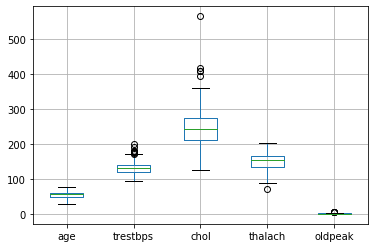

In [15]:
boxplot = data.boxplot(column=pruned_columns)

Based on the above graph, columns trestbps and chol has considerable amount of outliers. So lets go ahead and clean these columns.

In [16]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

data['trestbps']=remove_outlier(data,'trestbps')

data['chol']=remove_outlier(data,'chol')


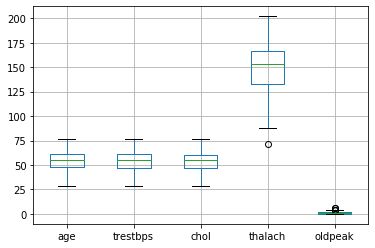

In [17]:
boxplot = data.boxplot(column=pruned_columns)

From the above graph we can observe that the outliers have been removed. The data is now clean and can be used for Feature Engineering.

## 3. Feature Engineering

Feature engineering deals with understanding the relation between independent variables and between independent & dependent variable. In other words, we need to find correlatin between input variables and input variables and output variables.

### Understanding the data

Lets first understand the data a bit. We will be using describe funtion that will give us overall distribution of data. We will also see how the data is distributed w.r.t output values.

In [18]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num (y)
count,302.000000,302.000000,302.000000,289.000000,297.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.410596,0.678808,3.165563,54.183391,54.272727,0.145695,0.986755,149.605960,0.327815,1.035430,1.596026,0.665563,4.718543,0.940397
std,9.040163,0.467709,0.953612,9.124007,9.039872,0.353386,0.994916,22.912959,0.470196,1.160723,0.611939,0.935142,1.940199,1.229384
min,29.000000,0.000000,1.000000,29.000000,29.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,47.000000,47.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,55.500000,1.000000,3.000000,55.000000,55.000000,0.000000,0.500000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,61.000000,60.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,77.000000,77.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


From the above matrix, we understand some key aspects about the data. For example, the average(mean) age is 54 and age with max values is 77.

Now lets calculate the data distribution w.r.t output variable.

In [19]:
data['num (y)'].value_counts()

0.0    163
1.0     55
2.0     36
3.0     35
4.0     13
Name: num (y), dtype: int64

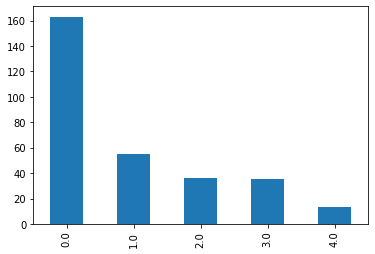

In [20]:
data['num (y)'].value_counts().plot(kind='bar')

As we can see the data is skewed. We need to do some feature engineering to solve this issue.. Our Approach will be to merge class 1,2,3 to class 1 as we do not have much samples compared to class 0. So our final classes will be 0 (no heart condition) & 1 (having heart condition).

In [21]:
def replace_class(class_value):
    if class_value > 0:
        return 1
    else:
        return 0
    
data['num (y)'] = data['num (y)'].map(replace_class)

data['num (y)'].value_counts()

0    163
1    139
Name: num (y), dtype: int64

Now that the skewness is resolved, lets find correlation between columns and see if we can furthur extract most relevant feature.

### Method 1 : Correlation Matrix

In [22]:
corr_matrix = data.corr().abs()

corr_matrix

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num (y)
age,1.000000,0.099925,0.112326,1.000000,1.000000,0.112245,0.146142,0.394448,0.094065,0.201083,0.156199,0.368415,0.126509,0.226668
sex,0.099925,1.000000,0.015342,0.095134,0.079806,0.042863,0.019386,0.048740,0.148019,0.099976,0.032671,0.087806,0.379651,0.279518
cp,0.112326,0.015342,1.000000,0.123279,0.109319,0.022524,0.075854,0.337136,0.382394,0.212589,0.171926,0.229945,0.269475,0.411625
trestbps,1.000000,0.095134,0.123279,1.000000,1.000000,0.098790,0.143442,0.406847,0.074686,0.205215,0.144281,0.384502,0.113662,0.223872
chol,1.000000,0.079806,0.109319,1.000000,1.000000,0.109498,0.132829,0.403063,0.104954,0.194563,0.154523,0.372395,0.124726,0.236979
fbs,0.112245,0.042863,0.022524,0.098790,0.109498,1.000000,0.062202,0.008067,0.031514,0.002907,0.042630,0.147936,0.060007,0.032923
restecg,0.146142,0.019386,0.075854,0.143442,0.132829,0.062202,1.000000,0.083591,0.087432,0.110879,0.127603,0.134486,0.022157,0.172840
thalach,0.394448,0.048740,0.337136,0.406847,0.403063,0.008067,0.083591,1.000000,0.378368,0.343821,0.389078,0.265881,0.274378,0.417701
exang,0.094065,0.148019,0.382394,0.074686,0.104954,0.031514,0.087432,0.378368,1.000000,0.291536,0.265491,0.144385,0.327262,0.430721
oldpeak,0.201083,0.099976,0.212589,0.205215,0.194563,0.002907,0.110879,0.343821,0.291536,1.000000,0.575415,0.304478,0.340942,0.429268


### Method 2 : HeatMap

The above information is not user friendly. Let plot a heat map to visualize relations better. We will use seaborn library.

In [23]:
import seaborn as sns
import numpy as np

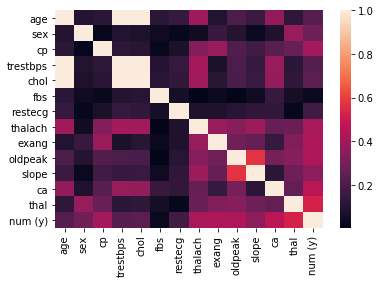

In [24]:
sns.heatmap(corr_matrix, 
        xticklabels=data.columns,
        yticklabels=data.columns)

### Method 3: Code base

Lets drop features that are highly correlated. Lets calculate upper traingle of cor-relation matrix.

In [25]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [26]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [27]:
data=data.drop(data[to_drop], axis=1)

In [28]:
data.head()

,age,sex,cp,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num (y)
0,67.0,1.0,4.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
1,67.0,1.0,4.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


As we can see, columns chol (cholestrol) and trestbps have been removed as they were highly correlated and would not contribute much to model scoring.

## 4. Model Building

Lets build a machine learning model. We will be using RandomForest Algorithm for predicting category for heart condition. 
Following are the steps that we will use here:
1. Lets first split our data into training and test sets.
2. Train the model using training set.
3. Predict the outcomes of the trained model using test sets. (performance evaluation).
4. Calculate baseline scores.

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
input_cols= [col for col in data.columns.tolist() if col != 'num (y)']

data_input = data[input_cols]
data_output = data['num (y)']

X_train, X_test, y_train, y_test = train_test_split(data_input, data_output, test_size=0.3)

Lets build our model now...

In [31]:
from sklearn.ensemble import RandomForestClassifier

#initialize mode
clf=RandomForestClassifier(n_estimators=150)
#n_estimators = number of decision trees.

#train the model
clf.fit(X_train,y_train)

#how the data will be,

#[first 11 columns - X_train,[num (y)]- y_train]


#test the model
y_pred=clf.predict(X_test)


#[first 11 columns - X_test]

Now that our model is trained, lets calculate accuracy.

In [32]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8351648351648352


Accuracy is a very basic measure of model evaluation. There are other score that we need to consider in real world usecases. The values like True postives, True Negatives, False postives and False Negative contribute to evalutions like **Precision** and **Recall**. We will be using confusion matrix to evaluate these scores. Lets go ahead and implement it.

In [33]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report


results = confusion_matrix(y_test, y_pred) 
  
print('Confusion Matrix :')
print(results) 
print('Accuracy Score : {}'.format(accuracy_score(y_test, y_pred)))
print('Report : ')
print(classification_report(y_test, y_pred))

Confusion Matrix :
[[41  6]
 [ 9 35]]
Accuracy Score : 0.8351648351648352
Report : 
              precision    recall  f1-score   support

           0       0.82      0.87      0.85        47
           1       0.85      0.80      0.82        44

    accuracy                           0.84        91
   macro avg       0.84      0.83      0.83        91
weighted avg       0.84      0.84      0.83        91



# Hyper-Parameter Tuning

First, we will define a base function that will help us plot validation curve with different hyper-parameter.

In [34]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

def plot_validation_graph(x_label, param_name,param_range):
	train_scores, test_scores = validation_curve(
									RandomForestClassifier(),
									X = X_train, y = y_train, 
									param_name = param_name, 
									param_range = param_range, cv = 3)
	
	# Calculate mean and standard deviation for training set scores
	train_mean = np.mean(train_scores, axis=1)
	train_std = np.std(train_scores, axis=1)
	
	# Calculate mean and standard deviation for test set scores
	test_mean = np.mean(test_scores, axis=1)
	test_std = np.std(test_scores, axis=1)
	
	
	plt.plot(num_est, train_mean, label="Training score", color="black")
	plt.plot(num_est, test_mean, label="Cross-validation score", color="dimgrey")
	
	# Plot accurancy bands for training and test sets
	#plt.fill_between(num_est, train_mean - train_std, train_mean + train_std, color="gray")
	#plt.fill_between(num_est, test_mean - test_std, test_mean + test_std, color="gainsboro")
	
	# Create plot
	plt.title("Validation Curve With Random Forest")
	plt.xlabel(x_label)
	plt.ylabel("Accuracy Score")
	plt.tight_layout()
	plt.legend(loc="best")
	plt.show()

## For n_estimators

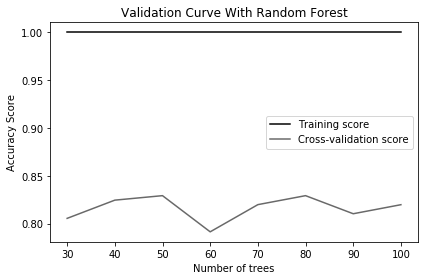

In [35]:
num_est=[30,40,50,60,70,80,90,100]
plot_validation_graph('Number of trees','n_estimators',num_est)

## For max_depth 

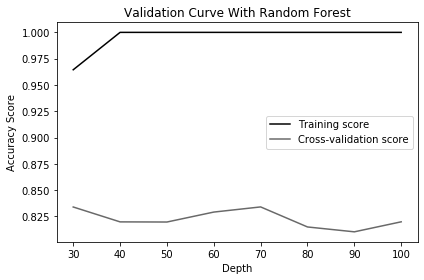

In [36]:
depth=[5,10,15,20,25,30,35,40]
plot_validation_graph('Depth','max_depth',depth)

## For min_samples_split

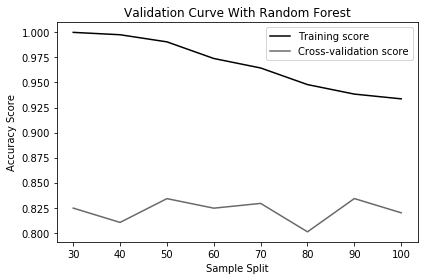

In [37]:
sample_split=[2,3,4,5,6,7,8,9]
plot_validation_graph('Sample Split','min_samples_split',sample_split)

## For min_samples_leaf

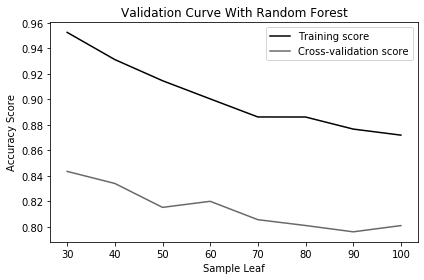

In [38]:
sample_leaf=[2,3,4,5,6,7,8,9]
plot_validation_graph('Sample Leaf','min_samples_leaf',sample_leaf)

## Grid Search

In [45]:
from sklearn.model_selection import GridSearchCV

n_estimators = [30,40,50,60,70,80,90,100]
max_depth = [5,10,15,20,25,30,35,40]
min_samples_split = [5,10,15,20,25,30,35,40]
min_samples_leaf = [2,3,4,5,6,7,8,9] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RandomForestClassifier(), hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 4096 candidates, totalling 12288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6376 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 9976 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 12076 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 12288 out of 12288 | elapsed:  4.7min finished


In [46]:
y_pred=bestF.predict(X_test)

In [47]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8461538461538461


In [48]:
results = confusion_matrix(y_test, y_pred) 
  
print('Confusion Matrix :')
print(results) 
print('Accuracy Score : {}'.format(accuracy_score(y_test, y_pred)))
print('Report : ')
print(classification_report(y_test, y_pred))

Confusion Matrix :
[[42  5]
 [ 9 35]]
Accuracy Score : 0.8461538461538461
Report : 
              precision    recall  f1-score   support

           0       0.82      0.89      0.86        47
           1       0.88      0.80      0.83        44

    accuracy                           0.85        91
   macro avg       0.85      0.84      0.85        91
weighted avg       0.85      0.85      0.85        91

